# Activity 4.2: line search and Eisenstat-Walker

**collaboration statement:**

In [1]:
%pip install numpy scipy matplotlib
import numpy as np
from scipy.optimize import rosen, rosen_der, rosen_hess
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


(50, 2)


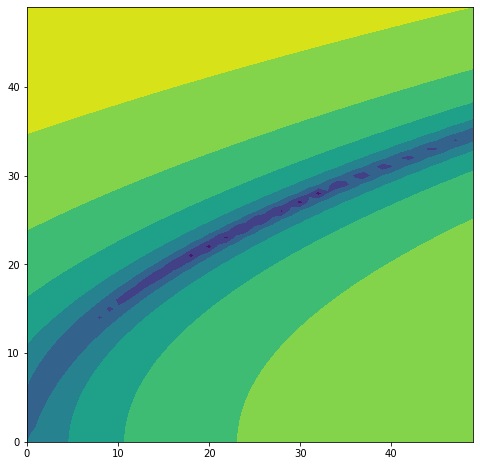

In [10]:
x = np.linspace(0,2)
y = np.linspace(0,2)

xy = np.vstack([x,y]).T
print(xy.shape)
z = []

for xpoint in x:
    for ypoint in y:
        z.append(rosen(np.array([xpoint, ypoint])))
z = np.array(z)
z.shape
ax = plt.figure(figsize=(8,8)).gca()
ax.contourf(np.log(z).reshape((50,50)))

We start with the generic form of a globalized Newton method.  We need:

1. A way to invert the Hessian of the objective function, or at least approximate the inverse in a way that gives us a descent direction
2. A way to use the gradient and the descent direction to pick a new point that has sufficiently decreased the objective function

In [27]:
def globalized_newton(f, f_der, f_hess, x0, linear_solver, globalizer, gtol=1.e-6, xtol=1.e-12, maxit=100):
    """Use Newton's method with globalization"""
    x = x0.copy()
    fx = f(x)
    gx = f_der(x)
    iter_count = 0
    while np.linalg.norm(gx) > gtol and iter_count < maxit:
        Hx = f_hess(x)
        p = linear_solver(Hx, -gx)
        d = globalizer(f, f_der, f_hess, x, fx, gx, Hx, p)
        x = x + d
        iter_count += 1
        if np.linalg.norm(d) < xtol:
            break
        fx = f(x)
        gx = f_der(x)
    return x, iter_count

We could opt not to globalize, and always take the Newton step.

In [12]:
def no_globalization(f, f_der, f_hess, x, fx, gx, Hx, p):
    return p

We test this out on the multidimensional Rosenbrock function, a standard test function for unconstrained optimization.

When unglobalized Newton converges, it can converge rapidly due to quadratic convergence near the solution.
But it may break down if the Hessian is singular.

In [13]:
n = 20
# Show that the vector of ones is a solution
o = np.ones((n,))
print(np.linalg.norm(rosen_der(o)))
Hoinv = np.linalg.inv(rosen_hess(o))

0.0


In [14]:
x0errs = []
niters = []
for i in range(100):
    x0 = np.ones((n,)) + np.random.randn(n)
    x, itr = globalized_newton(rosen, rosen_der, rosen_hess, x0, np.linalg.solve, no_globalization)
    x0errs.append(np.linalg.norm((x0-o).dot(Hoinv @ (x0 - o))))
    niters.append(itr)
ax = plt.figure(figsize=(8,5)).gca()
ax.set(title=r'$\|e_0\|_{H^{-1}}$ vs. iterations to convergence', xlabel=r'$\|e_0\|_{H^{-1}}$', ylabel='iterations')
ax.scatter(x0errs, niters)

LinAlgError: Singular matrix

Chances arer at least one of the above initial guesses failed due to a numerically singular Hessian.

**Activity 1 (1 points):** Provide a solver that returns $H^{-1}b$ when $H$ is invertible, and a good approximation otherwise.

_Hint:_ consider the pseudoinverse.

In [15]:
def approximate_solver(H, b):
    """Return an approximate inverse of H that will be the true inverse whenever H is nonsingular"""
    return np.linalg.pinv(H) @ b

In [16]:
x0errs = []
niters = []
for i in range(100):
    x0 = np.ones((n,)) + np.random.randn(n)
    x, itr = globalized_newton(rosen, rosen_der, rosen_hess, x0, approximate_solver, no_globalization)
    x0errs.append(np.linalg.norm((x0-o).dot(Hoinv @ (x0 - o))))
    niters.append(itr)
ax = plt.figure(figsize=(8,5)).gca()
ax.set(title=r'$\|e_0\|_{H^{-1}}$ vs. iterations to convergence', xlabel=r'$\|e_0\|_{H^{-1}}$', ylabel='iterations', xscale='log')
_ = ax.scatter(x0errs, niters)

We see on many iterations that there is the method doesn't converge within the maximum allowed iterations.  To address this, we introduce globalizaton.

We start by implementing a line search that takes into account both armijo conditions

In [17]:
def linesearch_armijo(g, g_der, g0, g0_der, lamda_init=1., alpha=1.e-4, beta=0.9, ltol=1.e-12, lamda_min=1.e-12, maxit=100):
    assert(g(0) == g0)
    assert(np.abs(g_der(0) - g0_der) < 1.e-8)
    assert(g0_der < 0.)
    lamda = lamda_init
    it = 0
    lamda_max = np.inf
    while it < maxit:
        gl = g(lamda)
        gpred = g0 + lamda * g0_der
        if (gl - g0) < alpha * lamda * (gpred - g0):
            # sufficient decrease
            gl_der = g_der(lamda)
            if gl_der > beta * g0_der:
                # sufficient reduction in the gradient
                break
            else:
                if lamda_max is np.inf:
                    lamda = lamda * 2.
                else:
                    lamda_min = lamda
                    lamda = (lamda_max + lamda_min) / 2.
        else:
            # insufficient decrease, step back
            lamda_max = lamda
            lamda = (lamda_max + lamda_min) / 2.
        it += 1
    return lamda

And we also start by using this line search on the gradient direction:

In [18]:
def linesearch_steepest_descent(f, f_der, f_hess, x, fx, gx, Hx, p, ltol=1.e-12, linesearch=linesearch_armijo):
    def g(lamda):
        return f(x - lamda * gx)
        
    def g_der(lamda):
        return -f_der(x - lamda * gx).dot(gx)
    if (gx.dot(gx) < ltol):
        return np.zeros(p.shape)
    lamda = linesearch(g, g_der, fx, -gx.dot(gx))
    return -lamda * gx

2721.7036327252267
1182.6451703154885
753.7386378854036
495.3367238482909
448.67274403335665
158.736103401824
134.99810409992193
132.11960229951112
134.15265111731404
136.57647820834828
139.2158345608628
141.08103150644598
141.965441851714
141.39619543765832
139.37225169814872
136.23059012893
132.20499091824243
128.09343888618918
123.86024501899641
120.0945517016994
116.41826650707549
113.24916693140352
110.19922560478058
107.61109304734451
105.16909417063096
103.12837828670315
101.2393006920972
99.6794992395722
98.25758695000928
6.601560352559118
10.784804439062151
5.292635977881231
4.980110367019676
5.253828943099764
5.6363793456607585
6.090073862327972
6.6233106587655755
7.246314327560205
7.97931615096395
8.83697032838499
9.84935597419295
2.4876025987053816
10.281822954264062
2.563734073358901
7.153462808588529
8.391224599308599
2.5353201618881185
13.419218294904674
2.8752832769958743
5.974054355419161
7.263659909856903
2.5675182610863927
7.541675154822108
2.6092670745536233
8.50977

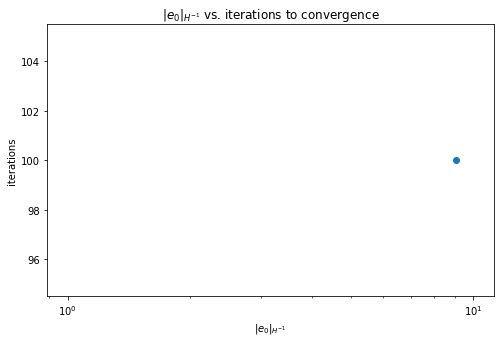

In [21]:
x0errs = []
niters = []
for i in range(1):
    x0 = np.ones((n,)) + np.random.randn(n)
    x, itr = globalized_newton(rosen, rosen_der, rosen_hess, x0, approximate_solver,
                               linesearch_steepest_descent)
    x0errs.append(np.linalg.norm((x0-o).dot(Hoinv @ (x0 - o))))
    niters.append(itr)
ax = plt.figure(figsize=(8,5)).gca()
ax.set(title=r'$\|e_0\|_{H^{-1}}$ vs. iterations to convergence', xlabel=r'$\|e_0\|_{H^{-1}}$', ylabel='iterations', xscale='log')
ax.scatter(x0errs, niters)

Even though the iteration always makes progress on reducing the objective function, it never converges within the allowed number of iterations.

If the objective function is a quadratic function, then steepest descent is like a linear solver strategy, and Saad in Chapter 5 says that its convergence factor is roughly

$$\frac{\kappa(H) - 1}{\kappa(H) + 1}.$$

As we approach the minimum of a smooth objective function, it looks more and more quadratic, so the condition number of $H(x^*)$ should tell us something about how quickly steepest descent converges:

In [22]:
print(np.linalg.norm(rosen_hess(o)))

4983.500376241583


This is pretty big, so we clearly need to use a quasi-Newton method to get a better search
direction.

When we globalize a quasi-Newton method, our default assumption should be to accept the full step length if possible, rather than trying to solve the line search exactly.  This is reflected in the use of a backtracking line search, which only uses the first Armijo condition (rather than trying to ensure that the norm of the gradient in the search direction is also reduced).

In [23]:
def linesearch_backtracking(g, g_der, g0, g0_der, lamda_init=1., alpha=1.e-4, lamda_min=1.e-12, maxit=100):
    assert(g(0) == g0)
    assert(np.abs(g_der(0) - g0_der) < 1.e-8)
    assert(g0_der < 0.)
    lamda = lamda_init
    it = 0
    lamda_max = np.inf
    while it < maxit:
        gl = g(lamda)
        gpred = g0 + lamda * g0_der
        if (gl - g0) < alpha * lamda * (gpred - g0):
            # sufficient decrease
            break
        else:
            # insufficient decrease, step back
            lamda_max = lamda
            lamda = (lamda_max + lamda_min) / 2.
        it += 1
    return lamda

In [24]:
def linesearch_newton(f, f_der, f_hess, x, fx, gx, Hx, p, ltol=1.e-30, linesearch=linesearch_backtracking):
    assert(p.dot(gx) < 0)
    if (np.abs(p.dot(gx)) < ltol):
        print("ltol", np.abs(p.dot(gx)))
        return np.zeros(p.shape)
    
    def g(lamda):
        return f(x + lamda * p)    
    def g_der(lamda):
        return f_der(x + lamda * p).dot(p)
    lamda = linesearch(g, g_der, fx, p.dot(gx))
    return lamda * p

**Activity 2 (1 point):** One way to ensure that the search direction
    
- looks like a Newton update
- points away from the gradient, $p^T \nabla f(x_k) < 0$

Is to solve the Newton system $H(x_k) p = - \nabla f(x_k)$ using the conjugate gradient method, but stopping the first time negative quadrature is account, that is anytime we encounter a vector $v$ such that $(Hv,v) < 0$.

Modify the implementation of CG below to ensure that the returned approximate solution
$x$ satisfies $(Hx, b) > 0$.

_Hint:_ you may need to handle the first iteration $i=0$ differently.

In [25]:
def steihaug_cg(H, b, tol=1.e-6, maxit=1000, callback=None):
    r = b.copy()
    p = b.copy()
    x = np.zeros(b.shape)
    rr = r.dot(r)
    beta = 0.
    for i in range(maxit):
        y = H @ p
        yp = y.dot(p)
        if yp <= 0:
            if i > 0:
                return x
            else:
                # gradient descent
                return p
        alpha = rr / yp
        x += alpha * p
        r -= alpha * y
        rrold = rr
        rr = r.dot(r)
        if callback is not None:
            callback(x, rr**0.5)
        if rr < tol*tol:
            return x
        beta = rr / rrold
        p = r + beta * p
    return x

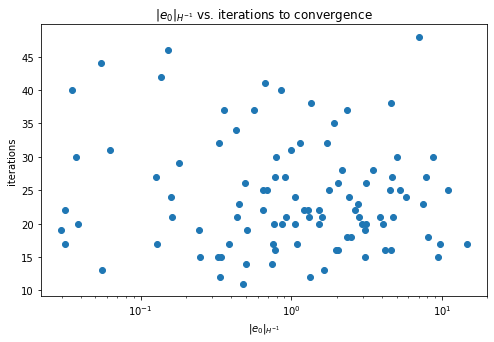

In [28]:
x0errs = []
niters = []
for i in range(100):
    x0 = np.ones((n,)) + np.random.randn(n)
    x, itr = globalized_newton(rosen, rosen_der, rosen_hess, x0, steihaug_cg,
                               linesearch_newton)
    x0errs.append(np.linalg.norm((x0-o).dot(Hoinv @ (x0 - o))))
    niters.append(itr)
ax = plt.figure(figsize=(8,5)).gca()
ax.set(title=r'$\|e_0\|_{H^{-1}}$ vs. iterations to convergence', xlabel=r'$\|e_0\|_{H^{-1}}$', ylabel='iterations', xscale='log')
ax.scatter(x0errs, niters)

When we use an iterative method to solve the Newton system, not all outer iterations are the same: the cost will be proportional to the number of inner Krylov iterations.  Because of this, it is useful to plot the convergence by cumulative inner iterations.

In [29]:
def globalized_newton_cg(f, f_der, f_hess, x0, globalizer, gtol=1.e-6, xtol=1.e-12, maxit=100, cg_tol_0=1.e-6, cgupdate=None):
    """Use Newton's method with globalization"""
    x = x0.copy()
    fx = f(x)
    gx = f_der(x)
    gxnorm = np.linalg.norm(gx)
    iter_count = 0
    residuals = []
    gxprev = 0
    while gxnorm > gtol and iter_count < maxit:
        Hx = f_hess(x)
        def callback(dx, rnorm): # rnorm is norm of linear residual
            residuals.append([np.linalg.norm(f_der(x+dx)), rnorm])
        if iter_count == 0 or cgupdate is None:
            cg_tol = cg_tol_0
        else:
            cg_tol = cgupdate(gxnorm, gxnormprev, gtol)
        p = steihaug_cg(Hx, -gx, callback=callback, tol=cg_tol)
        d = globalizer(f, f_der, f_hess, x, fx, gx, Hx, p)
        x = x + d
        iter_count += 1
        if np.linalg.norm(d) < xtol:
            print("short update", np.linalg.norm(d))
            break
        fx = f(x)
        gxnormprev = gxnorm
        gx = f_der(x)
        gxnorm = np.linalg.norm(gx)
        print("iter", iter_count, "f(x)", fx, "|g(x)|", gxnorm)
    return x, np.array(residuals).T, iter_count

iter 1 f(x) 6490.201364529623 |g(x)| 244.12172839687997
iter 2 f(x) 6390.812477335737 |g(x)| 300.31639824603315
iter 3 f(x) 6205.324526909872 |g(x)| 523.9979659241397
iter 4 f(x) 6076.2994823655035 |g(x)| 290.37429301064464
iter 5 f(x) 5505.386150710979 |g(x)| 1986.5048593344422
iter 6 f(x) 4848.108852599695 |g(x)| 3889.9225656495264
iter 7 f(x) 2525.83625844204 |g(x)| 1171.3051706372423
iter 8 f(x) 1317.5250618552213 |g(x)| 2299.3593843932563
iter 9 f(x) 1042.732418043387 |g(x)| 1697.1538422437168
iter 10 f(x) 685.0727508615041 |g(x)| 1328.9944044108292
iter 11 f(x) 628.5789744504257 |g(x)| 1706.5904531538988
iter 12 f(x) 55.815561845601074 |g(x)| 358.6260309528352
iter 13 f(x) 1.3431792969370377 |g(x)| 51.32739644690196
iter 14 f(x) 0.1668005584271771 |g(x)| 2.8300267220336757
iter 15 f(x) 0.11445607335015692 |g(x)| 11.55912834967763
iter 16 f(x) 0.03500455644610567 |g(x)| 1.1911782749718587
iter 17 f(x) 0.030139370968578973 |g(x)| 7.151248147865619
iter 18 f(x) 0.0008410922136624398

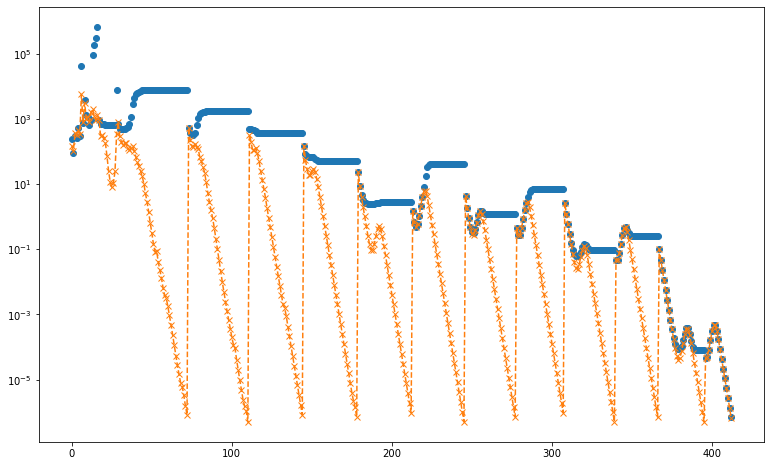

In [31]:
n = 1000
x0 = 0.5 * np.ones((n,))
x, ress, _ = globalized_newton_cg(rosen, rosen_der, rosen_hess, x0, linesearch_newton)
ax = plt.figure(figsize=(13,8)).gca()
plt.semilogy(ress[0], 'o')
plt.semilogy(ress[1], 'x--')

We see that there are a lot of wasted CG iterations where the CG residual norm decreases
but the nonlinear residual does not.

**Activity 3 (1 point):** Use "Choice 2" from Eisenstat & Walker (1996), with your choice of scaling parameters, to choose the tolerance of CG to minimize the number of inner CG iterations (you will implement a version of "Choice 1" in homework 4).

In [ ]:
def cgupdate_eisenstat_walker_choice_2(gxnorm, gxnormprev, gtol):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
n = 1000
x0 = 0.5*np.ones((n,))
x, ress, _ = globalized_newton_cg(rosen, rosen_der, rosen_hess, x0, linesearch_newton,
                                  cgupdate=cgupdate_eisenstat_walker_choice_2)
print(ress.shape)
print(np.linalg.norm(rosen_der(x)))
ax = plt.figure(figsize=(13,8)).gca()
plt.semilogy(ress[0])
plt.semilogy(ress[1], 'x--')